In [34]:
#|default_exp models.utils

# Model utils

In [35]:
import sys
sys.path.append('..')
from tsai.basics import *

In [36]:
#|export
from mocatml.models.conv_rnn import *
from mocatml.data import *
from fastcore.all import *
from fastai.vision.all import Learner, tensor

In [37]:
#|export
@patch
@delegates(Learner.get_preds)
def get_preds_iterative(self:Learner, dl, n_iter=1, track_losses=False, **kwargs):
    """
        Call get preds iteratively on a dataloader with a `DensityTupleTransform`
        TODO: Crashes if inner=True (kwargs), so it will produce invisible progress
        bars 
    """
    p, t = self.get_preds(dl=dl, **kwargs)
    ds_copy = copy(dl.ds) # Useful to move the gap without changing the original ds
    if track_losses:
        losses = [self.loss_func(p,t).item()]
    for _ in range(n_iter-1):
        ds_copy.data = ds_copy.data[:,ds_copy.h:] # Move h steps forward
        dl_new = dl.new(TfmdLists(range(len(ds_copy)), 
                                    DensityTupleTransform(ds_copy)))
        p,t = self.get_preds(dl=dl_new, **kwargs)
        if track_losses:
            losses.append(self.loss_func(p,t).item())
    if track_losses:
        return p, t, losses
    else:
        return p, t

In [38]:
# test
default_device(0)
lbk = 4
h = 4
n_iter = 4
data = np_load_compressed('TLE_density_10_15x15.npy.gz', 
                          path='../example_data')
ds = DensityData(data, lbk=lbk, h=h)
tl = TfmdLists(range(len(ds)), DensityTupleTransform(ds))
dls = tl.dataloaders(bs=32, shuffle=False, num_workers=0)
learn = Learner(dls=dls, 
                model=StackUnstack(SimpleModel()).to(default_device()),
                loss_func=StackLoss())
p,t,losses = learn.get_preds_iterative(dl=dls[0], n_iter=n_iter, track_losses=True);
test_eq(len(p), h)
test_eq(p[0].shape, [10, 1, 36, 99])
# Compare with the direct prediction made with a gap
ds_gap = copy(ds)
ds_gap.gap += (n_iter-1)*h
dl_gap = dls.new(TfmdLists(range(len(ds_gap)), DensityTupleTransform(ds_gap)))
p2,t2 = learn.get_preds(dl=dl_gap)
loss2 = learn.loss_func(p2,t2).item()
test_ne(p, p2)
test_eq(t, t2)

In [39]:
#|export
@patch
def get_individual_losses(self:Learner, p, t):
    """
        Get the loss for each element given predictions and targets computed
        in learn.get_preds
    """
    individual_losses = []
    for i in range(p[0].shape[0]):
        p_element = tuple(p_horizon[i] for p_horizon in p) 
        t_element = tuple(t_horizon[i] for t_horizon in t)
        loss = self.loss_func(p_element, t_element)
        individual_losses.append(loss)
    return tensor(individual_losses)

In [40]:
# test
individual_losses = learn.get_individual_losses(p,t)
test_eq(len(individual_losses), len(ds))
test_close(individual_losses.mean(), learn.loss_func(p,t), eps=1e-2)

In [41]:
#|export
@patch
def predict_at(self:Learner, idx, ds_idx=1, ds=None, with_input=False):
    """
        Predict at a given index on a given dataset, or in the learner's
    """
    ds = self.dls[ds_idx].ds if ds is None else ds
    tl = TfmdLists([idx], DensityTupleTransform(ds))
    dl = self.dls.new(tl)
    if with_input: 
        inp,p,t = self.get_preds(dl=dl, with_input=True, inner=True)
        return inp,p,t
    else:
        p, t = self.get_preds(dl=dl, with_input=False, inner=True)
        return p, t

In [42]:
# Test
p0, t0 = learn.predict_at(0, ds_idx=0)
test_eq(len(p0), h)
test_eq(p0[0].shape, [1, 1, 36, 99])
assert all_equal(torch.stack(t0, dim=learn.dim).squeeze(0),
            torch.stack(learn.dls.itemgot()[0][1], dim=0))

inp0,p0,t0  = learn.predict_at(0, ds_idx=0, with_input=True)
test_eq(len(p0), h)
test_eq(p0[0].shape, [1, 1, 36, 99])
test_eq(t0[0].shape, [1, 1, 36, 99])
test_eq(inp0[0].shape, [1, 1, 36, 99])
assert all_equal(torch.stack(inp0, dim=learn.dim).squeeze(0), 
          torch.stack(learn.dls.itemgot()[0][0], dim=0))
assert all_equal(torch.stack(t0, dim=learn.dim).squeeze(0),
            torch.stack(learn.dls.itemgot()[0][1], dim=0))

In [46]:
#|export
@patch
@delegates(Learner.predict_at)
def show_preds_at(self:Learner, idx, p=None, t=None, inp=None, with_input=None, 
                  with_targets=False, figsize=(5,3), **kwargs):
    """
        Show predictions at a given index
    """
    if t is not None: with_targets=True
    if inp is not None: with_input=True
    if p is None:
        inp, p, t = self.predict_at(idx, with_input=True, **kwargs)
        idx = 0
    if with_input:
        i_seq = DensitySeq.create([inp[i][idx] for i in range(len(inp))])
        i_seq.show(figsize=figsize, title="Input", x_disc=RP_DISC, y_disc=AM_DISC)
    p_seq = DensitySeq.create([p[i][idx] for i in range(len(p))])
    p_seq.show(figsize=figsize, start_epoch=len(p), title="Prediction", x_disc=RP_DISC, y_disc=AM_DISC)
    if with_targets:
        t_seq = DensitySeq.create([t[i][idx] for i in range(len(t))])
        t_seq.show(figsize=figsize, start_epoch=len(p), title="Target", x_disc=RP_DISC, y_disc=AM_DISC)

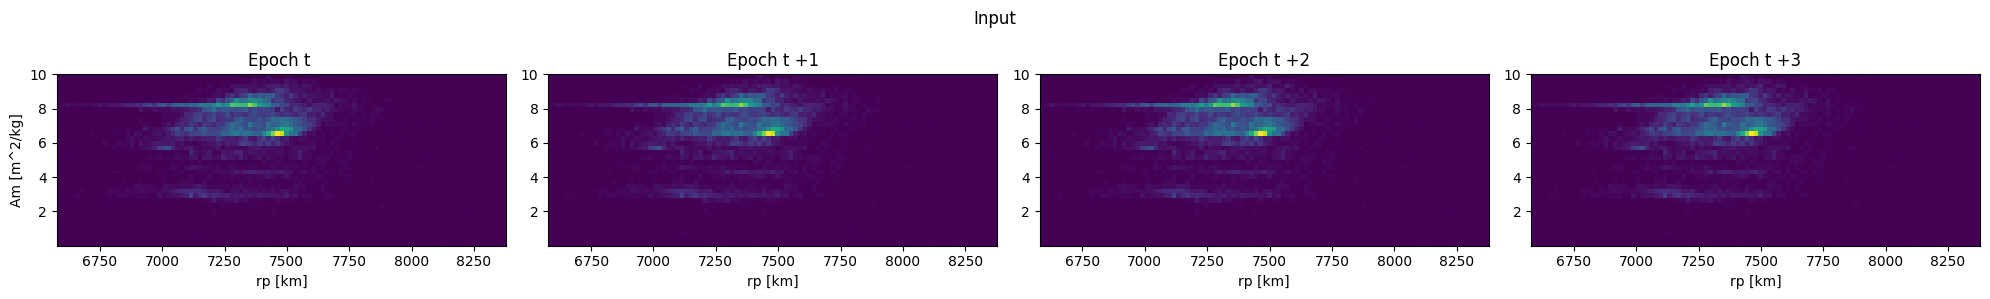

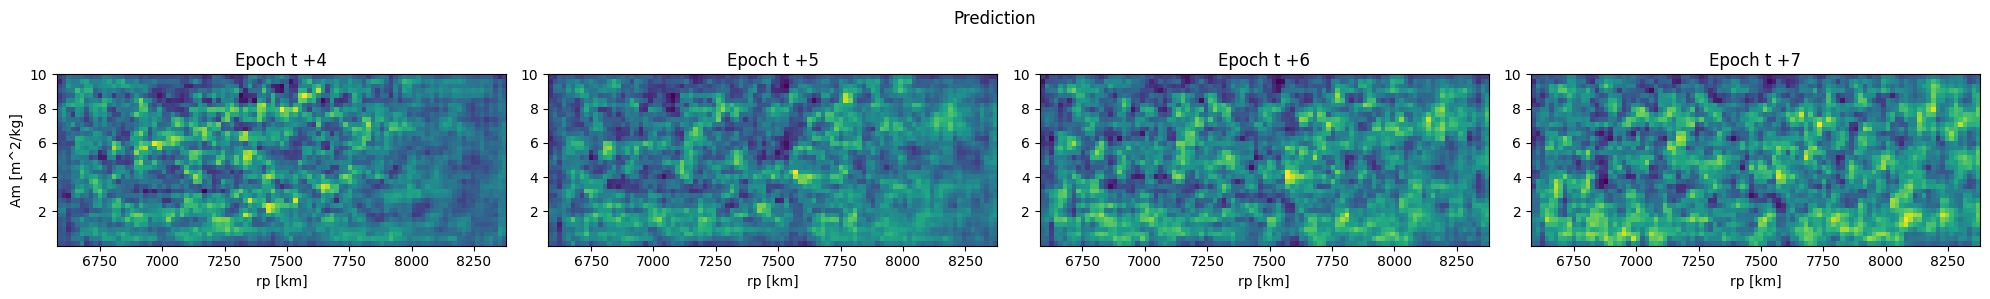

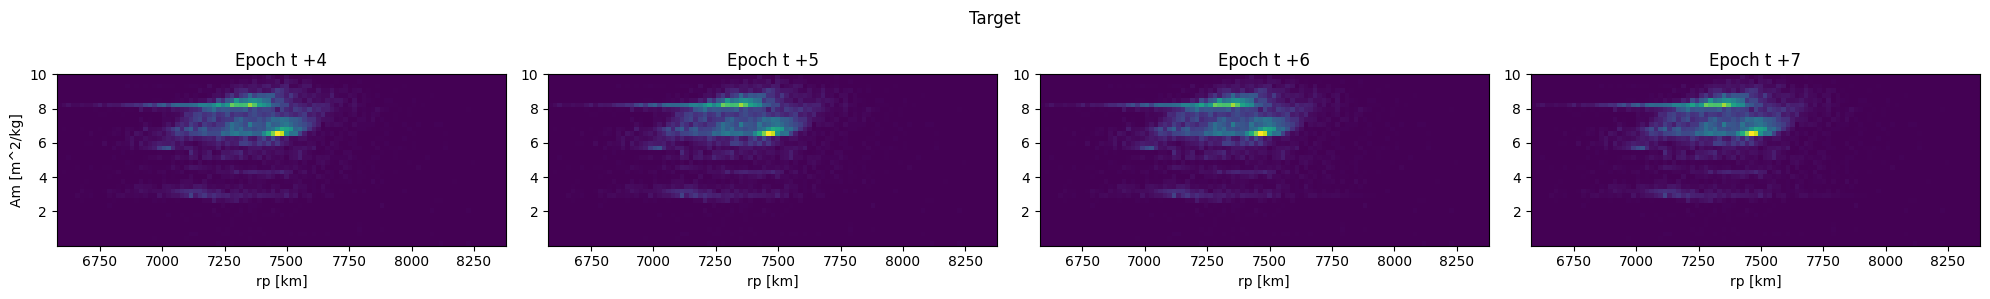

In [47]:
# Test
learn.show_preds_at(0, with_targets=True, with_input=True)

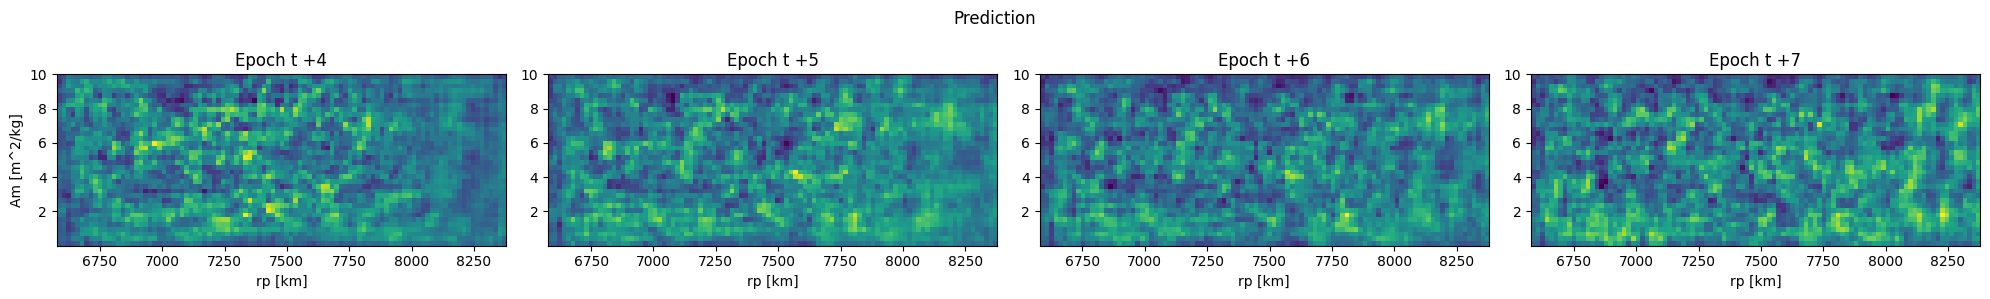

In [45]:
learn.show_preds_at(0, p, t)